# Prepare the dataset

In [3]:
import json
import pandas as pd
with open('important_features.json', 'r') as file:
    features = json.load(file)[:10]


all_data = pd.read_csv('axis2_demo_tablepart1_0.csv')
data_selected = all_data[features]


C:\Users\lia68085\AppData\Local\Temp\ipykernel_1492\3079364990.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
data_selected.head(10)

,Standardabweichung_y,Variance_z,Variance_y,Standardabweichung_z,Effektivwert_x,Mittlere_Absolute_Abweichung_y,Effektivwert_y,Standardabweichung_x,Mittelwert_x,Variance_x
0,163.966,220962,26911.8,469.831,657.526,117.401,571.115,328.477,569.600,108005.0
1,171.940,235057,29592.9,484.584,627.592,122.691,571.746,309.810,545.792,96078.5
2,156.322,256573,24460.9,506.277,651.770,111.817,566.507,324.498,565.248,105404.0
3,174.714,241982,30555.6,491.670,653.578,123.620,568.931,325.453,566.784,106026.0
4,162.434,268509,26411.1,517.919,661.006,128.562,586.402,339.697,567.040,115510.0
5,155.809,239210,24300.9,488.846,677.361,117.838,575.232,328.941,592.128,108310.0
6,164.774,254025,27177.7,503.757,646.115,122.937,575.516,329.079,556.032,108401.0
7,163.208,246906,26663.4,496.648,659.219,123.316,578.016,309.799,581.888,96071.6
8,158.789,230041,25239.3,479.386,653.327,126.857,587.128,311.643,574.208,97218.4
9,161.016,229656,25952.0,478.984,635.427,123.423,580.844,317.089,550.656,100646.0


# Define informer model

In [5]:
import copy
from pathlib import Path
import warnings
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch


In [6]:

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [7]:
import os
# get relative path
os.getcwd()

'c:\\Users\\lia68085'

In [8]:
# Data loading
train = pd.read_csv(r"C:\Users\lia68085\Thesis\masterarbeit\Dataanalyse\TFT_data\train.csv")

test = pd.read_csv(r"C:\Users\lia68085\Thesis\masterarbeit\Dataanalyse\TFT_data\test.csv")
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

df = pd.concat([train, test], axis = 0, ignore_index=True)
# replace the nan values with 0
#df = df.fillna(0)
# drop the line with num_sold is nan
df = df.dropna(subset=['num_sold'])

df.tail()


,row_id,date,country,store,product,num_sold
70123,70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614.0
70124,70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215.0
70125,70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158.0
70126,70126,2020-12-31,Spain,KaggleRama,Kaggle Recipe Book,135.0
70127,70127,2020-12-31,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,202.0


In [30]:
# Make sure 'date' is a datetime column
df['date'] = pd.to_datetime(df['date'])

# Correctly define the cutoff date for the training data
training_cutoff = pd.to_datetime("2020-12-31")  # Example date, replace with your actual cutoff

# Convert 'date' to 'time_idx'
df['time_idx'] = (df.date - df.date.min()).dt.days
df['time_idx']



0           0
1           0
2           0
3           0
4           0
         ... 
70123    1460
70124    1460
70125    1460
70126    1460
70127    1460
Name: time_idx, Length: 70128, dtype: int64

In [33]:

max_encoder_length = 36
max_prediction_length = 6
# Define the TimeSeriesDataSet for training
training = TimeSeriesDataSet(
    df[df.date <= training_cutoff],
    time_idx="time_idx",
    target="num_sold",
    group_ids=["country", "store", "product"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["country", "store", "product"],
    static_reals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["num_sold"],
)

# Update the validation dataset creation
# Note: You might need to adjust this part based on the actual max `time_idx` and how you've structured it
max_time_idx = df['time_idx'].max()
validation = TimeSeriesDataSet.from_dataset(training, df, min_prediction_idx=max_time_idx - max_prediction_length + 1, stop_randomization=True)


# Use my data to train the model

In [1]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
import json
from datetime import datetime

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [12]:
all_data= pd.read_csv('axis2_demo_tablepart1_0.csv')
all_data.columns
with open('important_features.json', 'r') as file:
    features = json.load(file)[:10]
features+=['ID','Schadensklasse','Timestamp']
data = all_data[features]
data['time_idx'] = data['Timestamp']
del data['Timestamp']

# 查看修改后的前几行数据
data.head()

C:\Users\28968\AppData\Local\Temp\ipykernel_22052\4155685184.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_idx'] = data['Timestamp']


,Standardabweichung_y,Variance_z,Variance_y,Standardabweichung_z,Effektivwert_x,Mittlere_Absolute_Abweichung_y,Effektivwert_y,Standardabweichung_x,Mittelwert_x,Variance_x,ID,Schadensklasse,time_idx
0,163.966,220962,26911.8,469.831,657.526,117.401,571.115,328.477,569.600,108005.0,1,2,1604490000
1,171.940,235057,29592.9,484.584,627.592,122.691,571.746,309.810,545.792,96078.5,2,2,1604490000
2,156.322,256573,24460.9,506.277,651.770,111.817,566.507,324.498,565.248,105404.0,3,2,1604490000
3,174.714,241982,30555.6,491.670,653.578,123.620,568.931,325.453,566.784,106026.0,4,2,1604490000
4,162.434,268509,26411.1,517.919,661.006,128.562,586.402,339.697,567.040,115510.0,5,2,1604490000


# 时间提取拆分的方法

In [ ]:
# import pandas as pd
# import datetime as dt

# # 假设data是你的DataFrame，并且'Timestamp'是Unix时间戳列
# data.loc[:,'date'] = pd.to_datetime(data.loc[:,'Timestamp'], unit='s')

# # 使用lambda函数和strftime来格式化日期时间
# data.loc[:,'date'] = data.loc[:,'date'].dt.strftime('%Y-%m-%d %H:%M:%S')
# data.dropna()
# # 查看最后几行数据
# data.tail()
import pandas as pd
import numpy as np
from datetime import datetime

# Sample DataFrame creation
# data = {
#     'date': pd.date_range(start='2022-05-17 17:06:40', periods=4, freq='H')
# }
# dates = pd.DataFrame(data)

# time_features function definition
# def time_features(dates, timeenc=0, freq='h'):
#     if timeenc == 0:
#         dates['year'] = dates.date.apply(lambda row: row.year)
#         dates['month'] = dates.date.apply(lambda row: row.month)
#         dates['day'] = dates.date.apply(lambda row: row.day)
#         dates['weekday'] = dates.date.apply(lambda row: row.weekday())
#         dates['hour'] = dates.date.apply(lambda row: row.hour)
#         dates['minute'] = dates.date.apply(lambda row: row.minute)
#         #dates['minute'] = dates['minute'].map(lambda x: x // 15)
#         freq_map = {
#             'y': ['year'], 'm': ['month'], 'w': ['month'], 'd': ['month', 'day', 'weekday'],
#             'b': ['month', 'day', 'weekday'], 'h': ['month', 'day', 'weekday', 'hour'],
#             't': ['month', 'day', 'weekday', 'hour', 'minute']
#         }
#         return dates[freq_map[freq.lower()]].values
#     else:
#         # For demonstration, just returning an empty array for timeenc=1
#         # Implement normalization as needed
#         return np.array([])

# # Testing the function
# print("Testing with freq='t' and timeenc=0:")
# print(time_features(data, timeenc=0, freq='t'))

# print("\nTesting with freq='y' and timeenc=0:")
# print(time_features(data, timeenc=0, freq='y'))

# # Example for timeenc=1 would require implementing the normalization part
# data["time_idx"] = data['year']*10+ data["month"]*10+data['day']
# data["time_idx"] -= data["time_idx"].min()

# data.groupby(["ID", "Schadensklasse"], observed=True)
# data

In [7]:
data.sample(10, random_state=521)


,Standardabweichung_y,Variance_z,Variance_y,Standardabweichung_z,Effektivwert_x,Mittlere_Absolute_Abweichung_y,Effektivwert_y,Standardabweichung_x,Mittelwert_x,Variance_x,ID,Schadensklasse,time_idx
8145,154.251,237061,23817.1,486.645,366.804,123.085,346.500,312.697,191.744,97877.5,8146,2,1610630000
1548,11324.800,24085200,128379000.0,4905.220,3970.960,9723.900,11330.900,3927.340,587.008,15439400.0,1549,1,1604490000
9038,164.051,261239,26939.7,510.859,365.999,125.848,345.553,324.399,169.472,105340.0,9039,2,1610630000
247,167.827,251734,28194.0,501.480,683.045,128.651,579.827,332.351,596.736,110568.0,248,2,1604490000
8962,157.310,239964,24771.2,489.616,364.744,119.972,340.586,309.802,192.512,96073.3,8963,2,1610630000
6352,11652.500,31781800,135916000.0,5634.720,2946.710,10013.300,11652.500,2936.490,245.248,8631610.0,6353,1,1606490000
4713,11111.300,33501900,123585000.0,5785.190,4837.360,9385.630,11113.600,4799.030,607.744,23053700.0,4714,1,1604580000
3441,12516.300,31492800,156816000.0,5609.040,3792.040,11016.300,12516.600,3723.530,717.568,13878600.0,3442,1,1604500000
6586,154.488,244880,23890.5,494.606,406.629,124.183,351.196,327.215,241.408,107177.0,6587,2,1606490000
1231,11231.500,27198100,126273000.0,5212.570,2825.180,9376.500,11242.900,2756.760,617.984,7607330.0,1232,0,1604490000


In [11]:
# data['time_count']=np.arange(0,len(data))
# for timename in data.time_idx.unique():
#     data.loc[data.time_idx==timename,'time_count']=np.arange(0,len(data.loc[data.time_idx==timename]))
# data['time_count']

C:\Users\lia68085\AppData\Local\Temp\ipykernel_17152\727671697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_count']=np.arange(0,len(data))


0          0
1          1
2          2
3          3
4          4
        ... 
9995    2687
9996    2688
9997    2689
9998    2690
9999    2691
Name: time_count, Length: 10000, dtype: int32

In [13]:
data["group"]=str("one_group")
name=data.columns.drop(['ID','time_idx','Schadensklasse','group']).tolist()


C:\Users\28968\AppData\Local\Temp\ipykernel_22052\652421109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["group"]=str("one_group")


In [14]:
data.head()

,Standardabweichung_y,Variance_z,Variance_y,Standardabweichung_z,Effektivwert_x,Mittlere_Absolute_Abweichung_y,Effektivwert_y,Standardabweichung_x,Mittelwert_x,Variance_x,ID,Schadensklasse,time_idx,group
0,163.966,220962,26911.8,469.831,657.526,117.401,571.115,328.477,569.600,108005.0,1,2,1604490000,one_group
1,171.940,235057,29592.9,484.584,627.592,122.691,571.746,309.810,545.792,96078.5,2,2,1604490000,one_group
2,156.322,256573,24460.9,506.277,651.770,111.817,566.507,324.498,565.248,105404.0,3,2,1604490000,one_group
3,174.714,241982,30555.6,491.670,653.578,123.620,568.931,325.453,566.784,106026.0,4,2,1604490000,one_group
4,162.434,268509,26411.1,517.919,661.006,128.562,586.402,339.697,567.040,115510.0,5,2,1604490000,one_group


In [15]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["ID"].max() - max_prediction_length

training = TimeSeriesDataSet(
  data,
  time_idx="ID",
  target=name,
  group_ids=["group"],
  max_encoder_length=max_encoder_length,

  max_prediction_length=max_prediction_length,
  static_categoricals=["group"],
  static_reals=["ID"],
  time_varying_known_categoricals=["group"],
  time_varying_known_reals=["ID"],
  time_varying_unknown_categoricals=[],
  time_varying_unknown_reals=name,
  #allow_missing_timesteps=True,
  #add_nan=True  # Fix: Set add_nan=True to allow unknown categories
)



In [17]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
#MAE()(baseline_predictions.output, baseline_predictions.y)
baseline_predictions.y

c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


((tensor([[154.2600, 172.3730, 152.9710, 174.2300, 166.2570, 156.9830]],
         device='cuda:0'),
  tensor([[2187, 2790, 1542, 3239, 3276, 1263]], device='cuda:0'),
  tensor([[23819.9004, 29742.0996, 23423.4004, 30386.5996, 27669.0996, 24668.1992]],
         device='cuda:0'),
  tensor([[499.8280, 510.6400, 491.9190, 537.2290, 543.8340, 488.6080]],
         device='cuda:0'),
  tensor([[393.0250, 402.8240, 381.1740, 408.5590, 395.9320, 403.1490]],
         device='cuda:0'),
  tensor([[110.2900, 124.2880, 120.5860, 126.0850, 119.1300, 120.8720]],
         device='cuda:0'),
  tensor([[327.8400, 335.6430, 345.9320, 330.9240, 330.3290, 342.0260]],
         device='cuda:0'),
  tensor([[344.7770, 344.7360, 326.7100, 362.9170, 349.8710, 336.7200]],
         device='cuda:0'),
  tensor([[188.6720, 208.3840, 196.3520, 187.6480, 185.3440, 221.6960]],
         device='cuda:0'),
  tensor([[118990., 118962., 106846., 131840., 122532., 113494.]],
         device='cuda:0')),
 None)

In [18]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\lightning\pytorch\trainer\setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Number of parameters in network: 9.9k


c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_steps=100` reached.
Finding best initial lr: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
Learning rate s

suggested learning rate: 0.06760829753919811


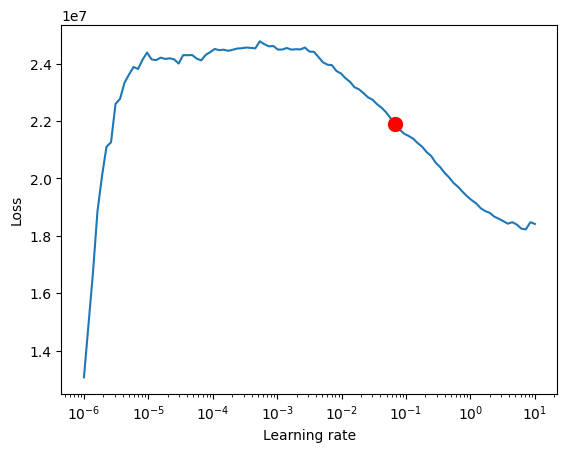

C:\Users\28968\AppData\Local\Temp\ipykernel_22052\4268711780.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [19]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [20]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 24.0k


In [21]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 176   
4  | static_variable_selection          | VariableSelectionNetwork        | 624   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 7.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 656   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Epoch 0:  52%|█████▏    | 26/50 [07:58<07:21,  0.05it/s, v_num=13, train_loss_step=2.05e+7]
                                                                           

c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 10: 100%|██████████| 50/50 [00:20<00:00,  2.45it/s, v_num=14, train_loss_step=7.96e+6, val_loss=1.99e+4, train_loss_epoch=7.44e+6]


In [22]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=1
    ,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2024-04-15 15:44:09,680] A new study created in memory with name: no-name-31120b87-726f-40fa-8a05-1d0f8acfbdc7
c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\tuning.py:124: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\tuning.py:148: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sug

{'gradient_clip_val': 0.07182311234318975, 'hidden_size': 30, 'dropout': 0.23728973912045445, 'hidden_continuous_size': 24, 'attention_head_size': 4, 'learning_rate': 0.05695866540996423}


In [23]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs\lightning_logs\version_14\checkpoints\epoch=10-step=550.ckpt


In [24]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
#MAE()(predictions.output, predictions.y)

c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\lightning\pytorch\trainer\setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


In [25]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [21]:
x_axis=raw_predictions.x
print(x_axis.keys())
print(x_axis['decoder_target'])
out=raw_predictions.output


# tensor=out.prediction[0]

# numpy_array = tensor.cpu().numpy()
# numpy_array[0]

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])
tensor([[23819.9004, 29742.0996, 23423.4004, 30386.5996, 27669.0996, 24668.1992]],
       device='cuda:0')


In [22]:
raw_predictions.output

Output(prediction=tensor([[[18833.0430, 21929.5723, 23389.6523, 24764.5879, 26042.4590,
          27769.6621, 29944.8594],
         [17983.5000, 21178.3789, 22761.0566, 24156.1855, 25501.4336,
          27317.4590, 29547.3711],
         [17180.4141, 20496.7871, 22230.0215, 23636.1543, 25050.9941,
          26986.4727, 29312.2402],
         [16290.1279, 19812.7617, 21760.9043, 23196.3496, 24659.9688,
          26722.8438, 29190.6484],
         [15210.1289, 19049.4043, 21352.0801, 22867.2324, 24365.4023,
          26533.8379, 29187.2539],
         [13949.0156, 18182.0234, 21008.2109, 22705.9805, 24262.5684,
          26491.2793, 29360.2324]]], device='cuda:0'), encoder_attention=tensor([[[[3.0339e-01, 1.1857e-01, 7.8236e-02, 4.2233e-02, 9.3847e-02,
           1.2373e-02, 1.3952e-02, 3.2463e-02, 1.3504e-02, 1.5071e-02,
           3.0524e-02, 1.1822e-02, 2.9040e-02, 2.0770e-02, 1.7984e-02,
           9.3989e-03, 1.1046e-02, 3.8844e-02, 1.1704e-02, 2.1308e-02,
           1.2039e-02, 1.0692e

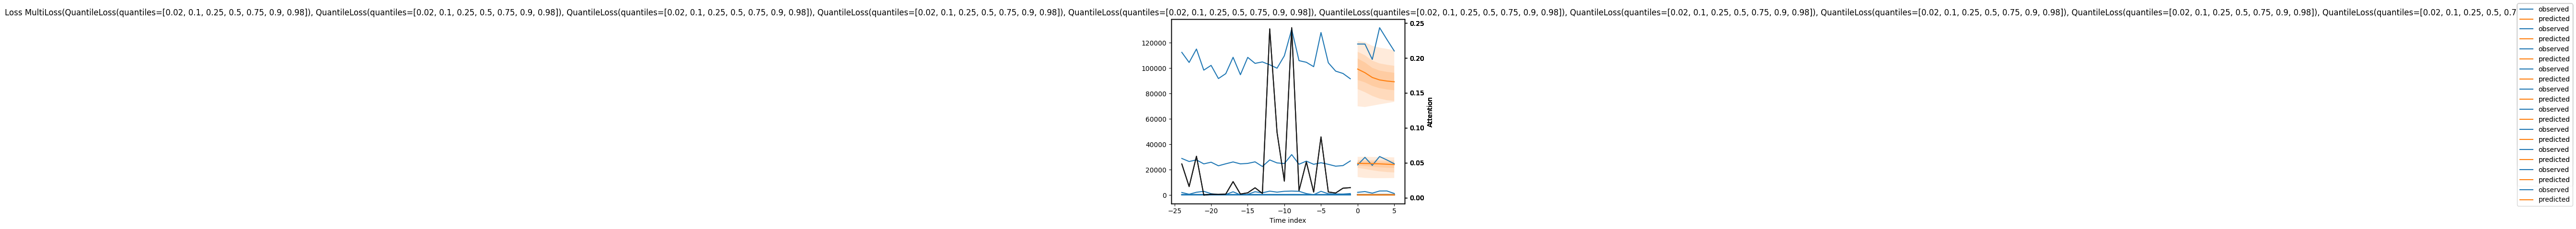

In [28]:
for idx in range(1):  # plot 6 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
#change the preditcion to the real value


In [29]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions.x['encoder_cont']


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor([[[-1.7316e+00, -1.7316e+00,  1.5682e+00,  2.0470e+03,  1.5683e+00,
           9.9628e-02,  1.3225e+00,  1.9857e+00,  8.4601e-01,  8.2364e-01,
           1.1959e+00,  8.4721e-01],
         [-1.7316e+00, -1.7316e+00,  4.4994e-01,  6.7300e+02,  4.2645e-01,
          -8.5300e-01,  2.2353e-01,  3.1411e-01,  2.3303e-02,  3.7464e-05,
           4.3825e-01,  2.1602e-02],
         [-1.7316e+00, -1.7316e+00,  1.0405e+00,  2.2480e+03,  1.0233e+00,
           2.5532e-01,  5.5673e-01,  8.1279e-01, -2.9548e-01,  1.0865e+00,
          -6.0167e-01,  1.1044e+00],
         [-1.7316e+00, -1.7316e+00, -4.5358e-01,  2.9900e+03, -4.5996e-01,
           1.1821e+00, -1.0809e+00, -7.3212e-01, -3.3829e-01, -6.4862e-01,
          -9.7307e-01, -6.5055e-01],
         [-1.7316e+00, -1.7316e+00,  1.8600e-01,  1.1050e+03,  1.6403e-01,
          -5.2029e-01, -5.4927e-01, -2.2343e-01, -5.9450e-01, -2.4385e-01,
          -6.0167e-01, -2.2878e-01],
         [-1.7316e+00, -1.7316e+00, -1.2058e+00,  3.7500e+02, -1.

In [30]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TypeError: only integer tensors of a single element can be converted to an index

In [39]:
# Filter the DataFrame to include only the entries with ID == 100
training

TimeSeriesDataSet[length=9971](
	time_idx='ID',
	target=['Standardabweichung_y', 'Variance_z', 'Variance_y', 'Standardabweichung_z', 'Effektivwert_x', 'Mittlere_Absolute_Abweichung_y', 'Effektivwert_y', 'Standardabweichung_x', 'Mittelwert_x', 'Variance_x'],
	group_ids=['group'],
	weight=None,
	max_encoder_length=24,
	min_encoder_length=24,
	min_prediction_idx=1,
	min_prediction_length=6,
	max_prediction_length=6,
	static_categoricals=['group'],
	static_reals=['ID'],
	time_varying_known_categoricals=['group'],
	time_varying_known_reals=['ID'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['Standardabweichung_y', 'Variance_z', 'Variance_y', 'Standardabweichung_z', 'Effektivwert_x', 'Mittlere_Absolute_Abweichung_y', 'Effektivwert_y', 'Standardabweichung_x', 'Mittelwert_x', 'Variance_x'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_

In [38]:
training.decoded_index


,group,time_idx_first,time_idx_last,time_idx_first_prediction
0,one_group,1,30,25
1,one_group,2,31,26
2,one_group,3,32,27
3,one_group,4,33,28
4,one_group,5,34,29
...,...,...,...,...
9966,one_group,9967,9996,9991
9967,one_group,9968,9997,9992
9968,one_group,9969,9998,9993
9969,one_group,9970,9999,9994


In [37]:
#training.filter(lambda x: (x.time_idx_first == 100))
training.decoded_index

,group,time_idx_first,time_idx_last,time_idx_first_prediction
0,one_group,1,30,25
1,one_group,2,31,26
2,one_group,3,32,27
3,one_group,4,33,28
4,one_group,5,34,29
...,...,...,...,...
9966,one_group,9967,9996,9991
9967,one_group,9968,9997,9992
9968,one_group,9969,9998,9993
9969,one_group,9970,9999,9994


In [102]:
name

['Standardabweichung_y',
 'Variance_z',
 'Variance_y',
 'Standardabweichung_z',
 'Effektivwert_x',
 'Mittlere_Absolute_Abweichung_y',
 'Effektivwert_y',
 'Standardabweichung_x',
 'Mittelwert_x',
 'Variance_x']

In [104]:

name.reverse()
name

['Variance_x',
 'Mittelwert_x',
 'Standardabweichung_x',
 'Effektivwert_y',
 'Mittlere_Absolute_Abweichung_y',
 'Effektivwert_x',
 'Standardabweichung_z',
 'Variance_y',
 'Variance_z',
 'Standardabweichung_y']

In [108]:
out=best_tft.predict(
        training.filter(lambda x: (x.group == "one_group") & (x.time_idx_first_prediction == 25)),
        mode="prediction",
    )
all_out=[]
for x in out:
    all_out.append(x.cpu().numpy())
all_out=np.array(all_out)
final=all_out.reshape(10,6)
final.shape
mat90 = np.rot90(final, -1)

predict=pd.DataFrame(mat90,columns=name)
predict

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


,Variance_x,Mittelwert_x,Standardabweichung_x,Effektivwert_y,Mittlere_Absolute_Abweichung_y,Effektivwert_x,Standardabweichung_z,Variance_y,Variance_z,Standardabweichung_y
0,99701.156250,585.500732,316.202393,571.042480,122.057755,642.205688,495.038757,25382.167969,1.713900,150.173325
1,100029.437500,587.221680,317.883118,571.102234,121.905876,641.673340,492.651550,24501.595703,1.767101,149.639954
2,100114.570312,587.384949,318.975403,571.288208,121.704872,642.271912,491.608063,24130.714844,1.701681,149.664825
3,100156.781250,587.605164,319.520508,571.498535,121.574661,643.083862,491.227905,23985.609375,1.647093,149.819885
4,100177.125000,587.822632,319.857483,571.662231,121.500435,643.729004,491.068054,23909.355469,1.609361,149.971054
5,100170.539062,587.981140,320.082611,571.767456,121.462051,644.160645,491.000763,23865.111328,1.582922,150.084335


In [121]:
true=pd.DataFrame(data[name][25:31])
true_final=true.reset_index(drop=True)


true_final

,Variance_x,Mittelwert_x,Standardabweichung_x,Effektivwert_y,Mittlere_Absolute_Abweichung_y,Effektivwert_x,Standardabweichung_z,Variance_y,Variance_z,Standardabweichung_y
0,103636.0,596.992,321.764,576.313,122.020,678.183,505.736,26398.1,256024,162.394
1,109050.0,579.584,330.062,598.241,135.380,666.977,492.154,27616.6,242458,166.099
2,109565.0,568.576,330.841,578.922,117.129,657.825,502.282,23149.2,252539,152.073
3,108400.0,573.440,329.077,574.262,123.465,661.154,479.054,27991.2,229722,167.222
4,107482.0,573.440,327.680,579.658,125.239,660.460,486.526,27143.3,236945,164.670
5,104745.0,602.624,323.482,586.123,130.970,683.956,495.603,28101.4,245868,167.551


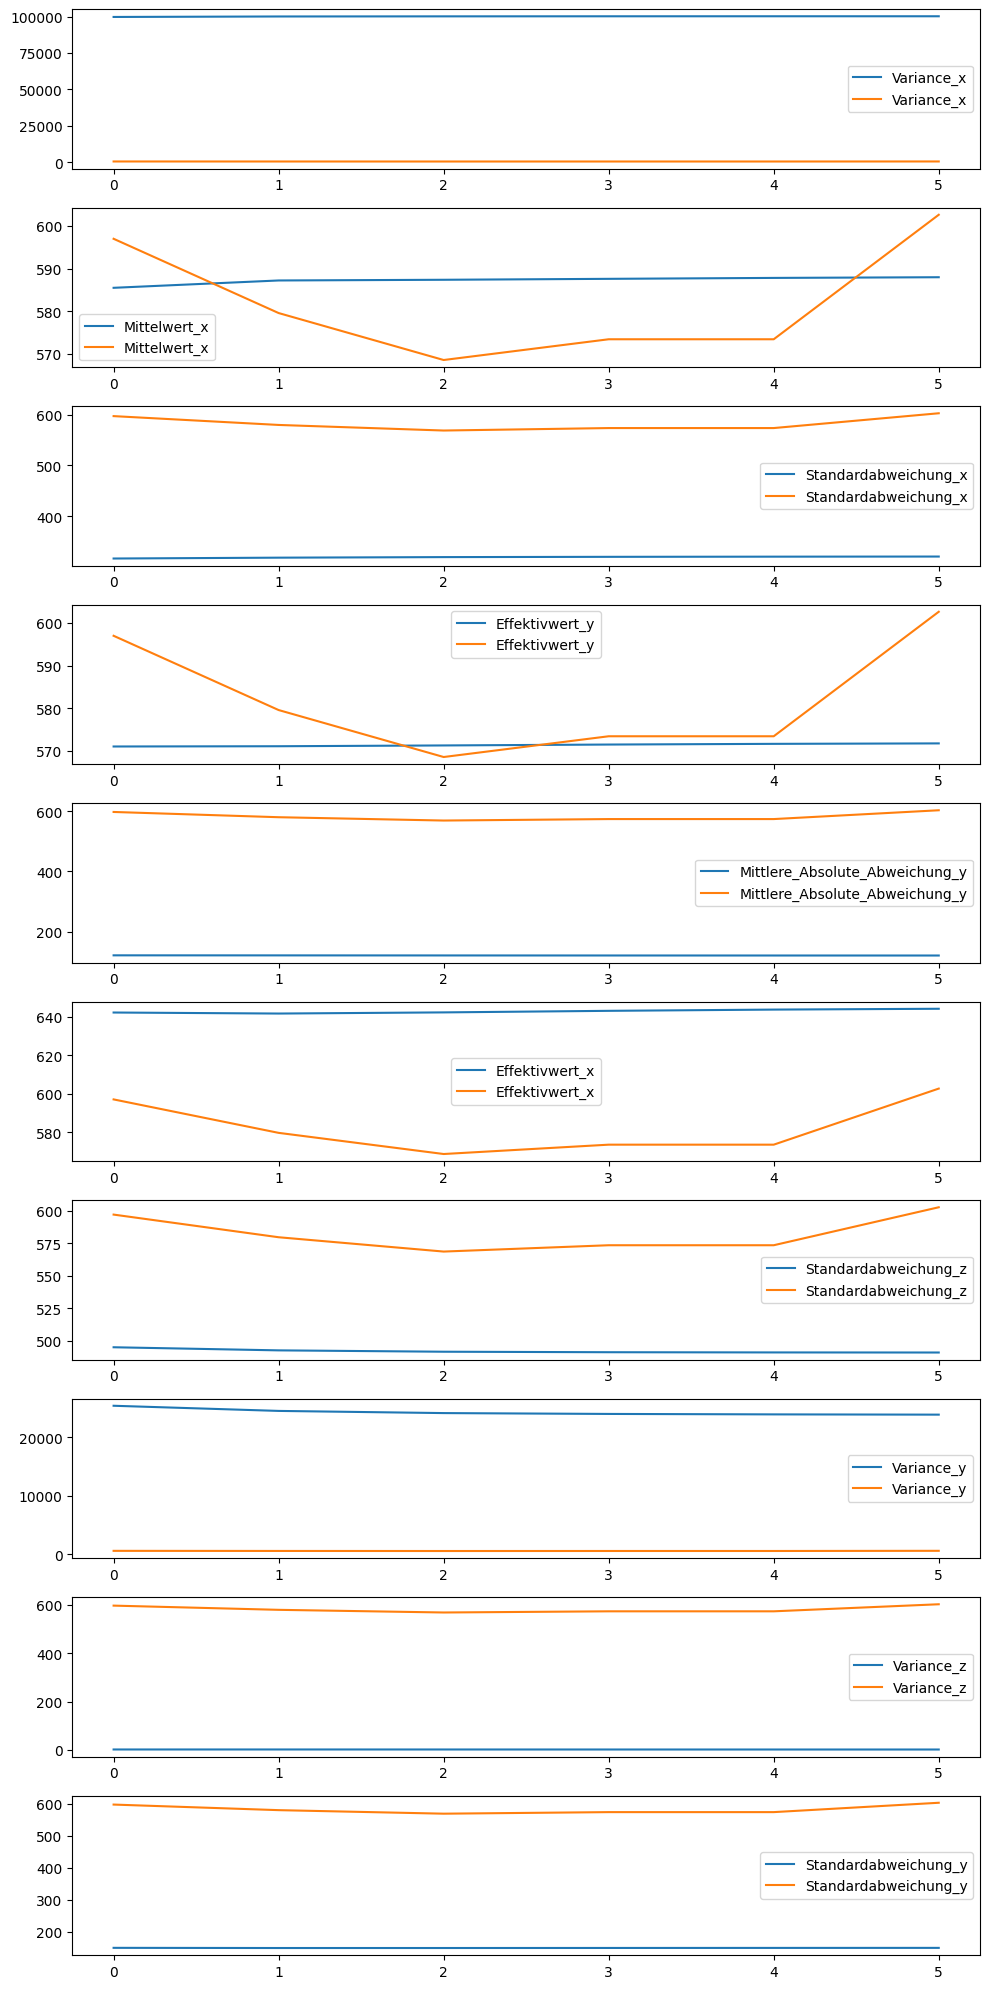

In [123]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(len(predict.columns),1,figsize=(10,2*len(predict.columns)))
# draw a vertical line when the value of column "Timestamp" changes
for i in range(len(predict.columns)):
    axs[i].plot(predict.iloc[:,i],label=predict.columns[i])
    axs[i].plot(true_final.iloc[:,1],label=predict.columns[i])
    axs[i].legend()
    # let the vertical line from top to bottom, not from 0 to 1000
    # x=0
    # for j in length:
    #     x+=j
    #     if 0<x<7000:
    #         axs[i].axvline(x, color='red',linestyle="--")

plt.tight_layout()
plt.show()


,Standardabweichung_y,Variance_z,Variance_y,Standardabweichung_z,Effektivwert_x,Mittlere_Absolute_Abweichung_y,Effektivwert_y,Standardabweichung_x,Mittelwert_x,Variance_x
25,162.394,256024,26398.1,505.736,678.183,122.020,576.313,321.764,596.992,103636.0
26,166.099,242458,27616.6,492.154,666.977,135.380,598.241,330.062,579.584,109050.0
27,152.073,252539,23149.2,502.282,657.825,117.129,578.922,330.841,568.576,109565.0
28,167.222,229722,27991.2,479.054,661.154,123.465,574.262,329.077,573.440,108400.0
29,164.670,236945,27143.3,486.526,660.460,125.239,579.658,327.680,573.440,107482.0
30,167.551,245868,28101.4,495.603,683.956,130.970,586.123,323.482,602.624,104745.0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increa

[28618.294921875, 24537.884765625, 30566.8125, 32630.310546875, 31344.796875, 29498.703125, 24464.224609375, 25299.5546875, 25697.626953125, 25024.333984375, 25366.58984375, 25038.927734375, 26914.033203125, 24318.447265625, 25723.138671875, 23929.86328125, 23332.708984375, 23475.095703125, 23663.4296875, 26386.501953125]


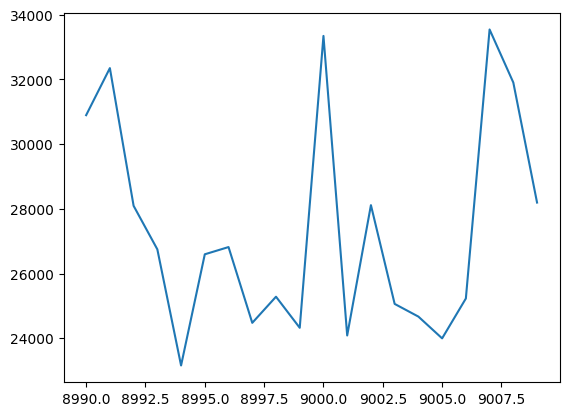

In [36]:
out=[]
for i in range(8990,9010):
    out.append(best_tft.predict(
        training.filter(lambda x: (x.group == "one_group") & (x.time_idx_first_prediction == i)),
        mode="prediction",
    )[0][0].tolist())

print(out)
# plot the true


In [46]:
out
true=data.Variance_y[8990:9010]
true=true.tolist()


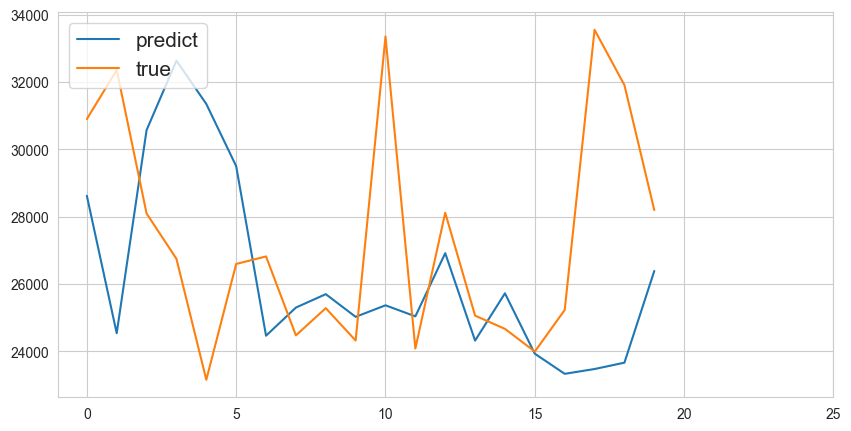

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
plt.plot(out, label="predict")
plt.plot(true, label="true")
plt.legend(loc="upper left", prop={'size': 15})
plt.xticks(range(0, 26, 5))

plt.show()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[<Figure size 640x480 with 11 Axes>,
 <Figure size 640x480 with 11 Axes>,
 <Figure size 640x480 with 11 Axes>,
 <Figure size 640x480 with 11 Axes>,
 <Figure size 640x480 with 11 Axes>,
 <Figure size 640x480 with 11 Axes>,
 <Figure size 640x480 with 11 Axes>,
 <Figure size 640x480 with 11 Axes>,
 <Figure size 640x480 with 11 Axes>,
 <Figure size 640x480 with 11 Axes>]

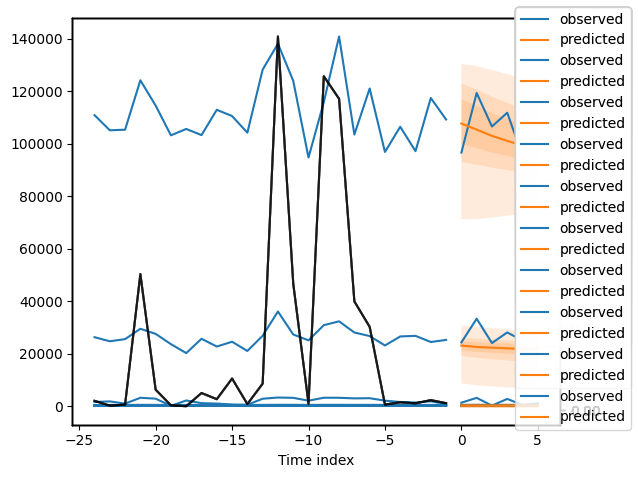

In [35]:
raw_prediction = best_tft.predict(
    training.filter(lambda x: (x.group == "one_group") & (x.time_idx_first_prediction == 9000)),
    mode='raw',
    return_x=True,
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0)

# Groupby 用法

In [53]:
company=["A","B","C"]

data=pd.DataFrame({
    "company":[company[x] for x in np.random.randint(0,len(company),10)],
    "salary":np.random.randint(5,50,10),
    "age":np.random.randint(15,50,10)
}
)
data

,company,salary,age
0,B,39,27
1,B,37,31
2,C,38,49
3,C,28,45
4,A,46,36
5,C,11,43
6,C,10,25
7,A,25,23
8,A,35,17
9,C,29,24


In [58]:
data['avg_salary'] = data.groupby('company')['salary'].transform('median')
data["avg_volume_by_sku"] =data.groupby(["company", "age"], observed=True).salary.transform("mean")
data

,company,salary,age,avg_salary,avg_volume_by_sku
0,B,39,27,38.0,39.0
1,B,37,31,38.0,37.0
2,C,38,49,28.0,38.0
3,C,28,45,28.0,28.0
4,A,46,36,35.0,46.0
5,C,11,43,28.0,11.0
6,C,10,25,28.0,10.0
7,A,25,23,35.0,25.0
8,A,35,17,35.0,35.0
9,C,29,24,28.0,29.0


In [22]:
group = data.groupby("company")
list(group)

[('A',
    company  salary  age
  0       A      37   44
  3       A      13   25
  8       A      14   30
  9       A      36   42),
 ('B',
    company  salary  age
  1       B      47   48
  7       B      46   38),
 ('C',
    company  salary  age
  2       C      41   17
  4       C      32   42
  5       C      37   33
  6       C      36   30)]

In [23]:
data.groupby("company").agg('mean')

,salary,age
company,,
A,25.0,35.25
B,46.5,43.00
C,36.5,30.50


In [24]:
data.groupby('company').agg({'salary':'median','age':'mean'})

,salary,age
company,,
A,25.0,35.25
B,46.5,43.00
C,36.5,30.50


In [29]:
data['avg_salary'] = data.groupby('company')['salary'].transform('median')
data

,company,salary,age,avg_salary
0,A,37,44,25.0
1,B,47,48,46.5
2,C,41,17,36.5
3,A,13,25,25.0
4,C,32,42,36.5
5,C,37,33,36.5
6,C,36,30,36.5
7,B,46,38,46.5
8,A,14,30,25.0
9,A,36,42,25.0
